## Implémentation des GANs sur MNIST

#### Imports

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os


#### 1. Chargement du Dataset

In [17]:
with np.load("../input/mnist-numpy/mnist.npz") as data: #sur kaggle, ajouté en input
    X_train = data["x_train"]
    y_train = data["y_train"]


X_train = (X_train.astype(np.float32) / 255.0 - 0.5) * 2 #transformer tous les pixels pr qu'ils soient dans [-1,1]
X_train = np.expand_dims(X_train, axis=1) #-> (N,1,28,28) car pytorch a besoin d'un canal (le 1 ici car noir et blanc)
X_tensor = torch.tensor(X_train)
y_tensor = torch.tensor(y_train)


In [18]:
#Dataset et DataLoader
dataset = TensorDataset(X_tensor, y_tensor) 
dataloader = DataLoader(dataset, batch_size=128, shuffle=True) #on regarde en petit grp de 128 images (batch) car 60000 c trop lourd


#### 2. Partie Config

In [19]:

latent_dim = 100 #taille du bruit
image_size = 28
epochs = 50 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("generated_images", exist_ok=True)

#### 3.Construction du GAN (Générateur et Discriminateur)

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128), #100->128
            nn.LeakyReLU(0.2), #activation
            nn.Linear(128, 256), #128 -> 256
            nn.BatchNorm1d(256), #normalisation
            nn.LeakyReLU(0.2), #activ
            nn.Linear(256, 512), #256 -> 512
            nn.BatchNorm1d(512), #norm
            nn.LeakyReLU(0.2), #activ
            nn.Linear(512, image_size * image_size),#512 -> 28*28 (taille de Mnist)
            nn.Tanh() #-> sortie entre [-1,1] pour etre comme l'image d'origine
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), 1, image_size, image_size) #pour voir l'image!!

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1), #a la fin 1 dim
            nn.Sigmoid() #la proba entre 0 et 1
        )

    def forward(self, img):
        flat = img.view(img.size(0), -1)
        return self.model(flat)

#### 4.Initialisation

In [21]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) #pour changer les poids
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss_fn = nn.BCELoss() #loss function


#### 5.Entraînement du GAN et résultats


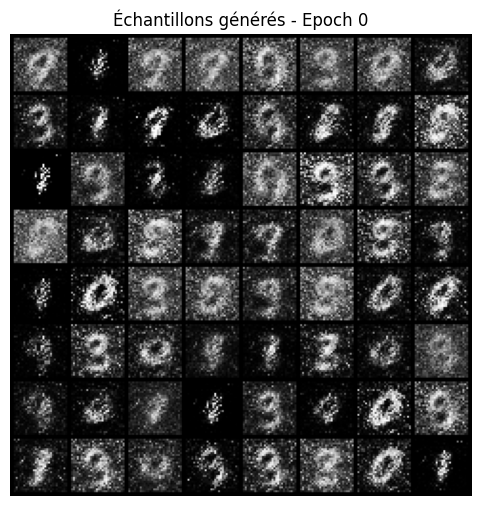

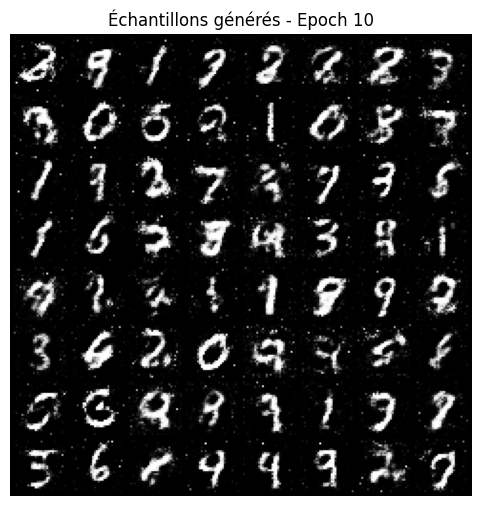

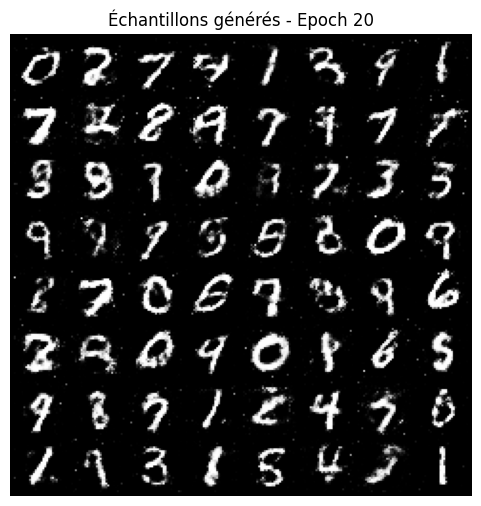

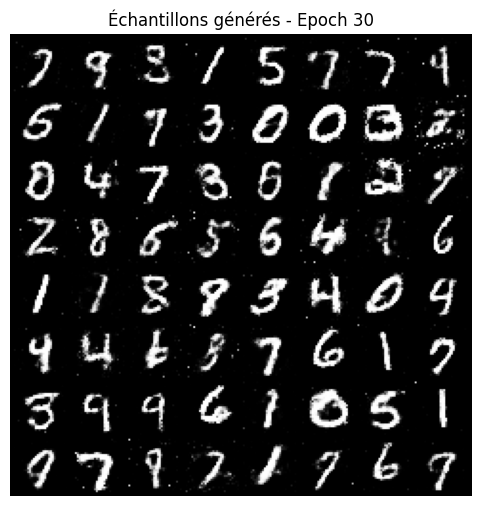

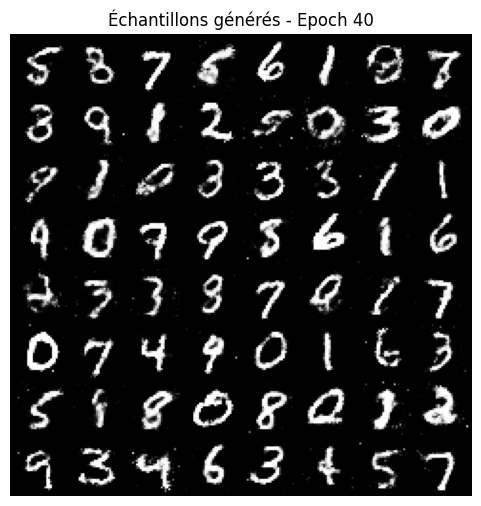

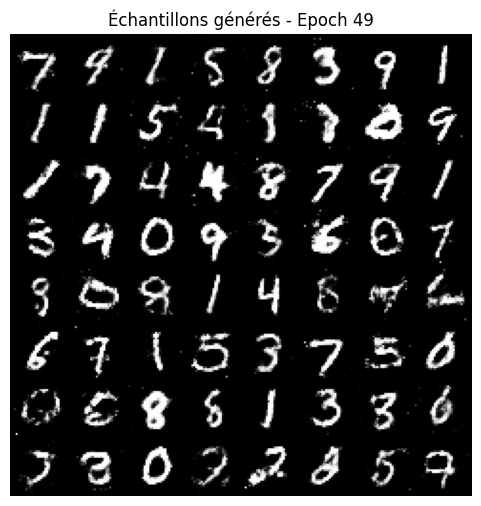

In [22]:

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Générer du bruit + images fake
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)

        # Train Discriminateur
        optimizer_D.zero_grad()
        real_loss = loss_fn(discriminator(real_imgs), valid)
        fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        #Train Generator
        optimizer_G.zero_grad()
        g_loss = loss_fn(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        #if i % 100 == 0:
            #print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
            #      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
            
    if epoch % 10 == 0 or epoch == 49:
        with torch.no_grad():
            sample_z = torch.randn(64, latent_dim, device=device)
            generated = generator(sample_z).cpu()
    
            grid = make_grid(generated, nrow=8, normalize=True)
            save_image(grid, f"generated_images/epoch_{epoch:03d}.png")
    
            npimg = grid.permute(1, 2, 0).numpy()
            plt.figure(figsize=(6, 6))
            plt.imshow(npimg, cmap="gray")
            plt.axis("off")
            plt.title(f"Échantillons générés - Epoch {epoch}")
            plt.show()



Fin de l'implémentation, on remarque le progrès du modèle en comparant l'epoch0 à l'epoch49, on peut reconnaître des numéros MNIST